In [ ]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from IPython.display import display, Image
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END

# Load environment variables
load_dotenv()

# Define functions
def add(a: int, b: int) -> int:
    """Add a and b.
    Args:
        a: first int
        b: second int   
    """
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# Define Gemma2 model
llm = ChatGroq(model="gemma2-9b-it")

# Binding functions with model
llm_with_tools = llm.bind_tools([add, multiply])

def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Bind tools
llm_with_tools = llm.bind_tools([add, multiply])

# Define async node for LLM + tool call
async def tool_calling_llm(state: MessagesState):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {"messages": [result]}

# Build state graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([add, multiply]))

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", tools_condition)

builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    {
        "tool_call": "tools",
        "end": END
    }
)

# Compile the graph
graph = builder.compile()

# Display flow
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Found edge ending at unknown node `<function tools_condition at 0x000001AC33D8EA20>`

In [8]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image

import asyncio

# Load environment variables
load_dotenv()

# Define tools
def add(a: int, b: int) -> int:
    return a + b

def multiply(a: int, b: int) -> int:
    return a * b

# Create LLM with tool binding
llm = ChatGroq(model="gemma-7b-it")  # Use gemma2-9b-it if it works for you
llm_with_tools = llm.bind_tools([add, multiply])

# Async tool-calling function for LangGraph node
async def tool_calling_llm(state: MessagesState):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {"messages": [result]}

# Build the state graph
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([add, multiply]))

# ✅ Correct: use add_conditional_edges, not add_edge with tools_condition
builder.add_edge(START, "tool_calling_llm")

builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    {
        "tool_call": "tools",
        "end": END
    }
)

builder.add_edge("tools", END)

# Compile the graph
graph = builder.compile()

# ✅ Optional: visualize if supported
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph visualization failed (only works in notebooks with graphviz installed).")


ValueError: Function must have a docstring if description not provided.

In [1]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq

# Load environment variables
load_dotenv()

# Define functions
def add(a: int, b: int) -> int:
    """Add a and b.
    Args:
        a: first int
        b: second int   
    """
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# Define Gemma2 model
llm = ChatGroq(model="gemma2-9b-it")

# Binding functions with model
llm_with_tools = llm.bind_tools([add, multiply])
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001A86B3D9940>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001A86B3DA510>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b.\nArgs:\n    a: first int\n    b: second int   ', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

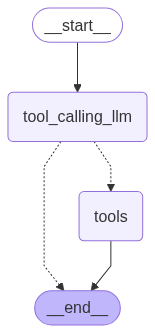

In [2]:
# Build Graph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

def tool_calling_llm(state: MessagesState):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

graph_builder = StateGraph(MessagesState)

graph_builder.add_node('tool_calling_llm', tool_calling_llm)
graph_builder.add_node('tools', ToolNode([add, multiply]))

graph_builder.add_edge(START, 'tool_calling_llm')
graph_builder.add_conditional_edges(
    'tool_calling_llm',
    tools_condition
)
graph_builder.add_edge('tools', END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. Then the result multiply by 5 and add 15.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then the result multiply by 5 and add 15.
================================== Ai Message ==================================
Tool Calls:
  add (pfv2ng4jb)
 Call ID: pfv2ng4jb
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7


In [13]:
import os
from dotenv import load_dotenv
from typing import Annotated
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import add_messages
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Load environment variables
load_dotenv()

# Access OPENAI and LANGSMITH api key
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")

# Define state
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# Define model
model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

def make_default_graph():
    """ Make a simple LLM Agent. """ 
    
    def call_model(state: State):
        return {'messages': [model.invoke(state['messages'])]}
    
    graph_workflow = StateGraph(State)
    graph_workflow.add_node('agent', call_model)
    graph_workflow.add_edge(START, 'call_model')
    graph_workflow.add_edge('call_model', END)
    graph = graph_workflow.compile()
    return graph

def make_alternate_graph():
    """ Make a tool calling agent. """
    
    @tool
    def add(a: float, b: float) -> float:
        """ Adds number a and b """
        return a + b
    
    tool_node = ToolNode([add])
    model_with_tools = model.bind_tools([add])
    
    def call_model(state: State):
        return {'messages': [model_with_tools.invoke(state['messages'])]}
    
    def should_continue(state: State):
        if state['messages'][-1].tool_calls:
            return 'tools'
        else:
            return END
    
    graph_workflow = StateGraph(State)    
    graph_workflow.add_node("agent", call_model)
    graph_workflow.add_node("tools", tool_node)
    
    graph_workflow.add_edge(START, "agent")
    graph_workflow.add_conditional_edges(
        "agent",
        tools_condition
    )
    graph_workflow.add_edge("tools", "agent")
    
    graph = graph_workflow.compile()
    return graph

agent = make_alternate_graph()


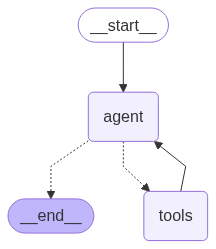

In [14]:
graph = make_alternate_graph()
graph

In [15]:
graph.invoke({"messages": "Add 2 and 3"})

{'messages': [HumanMessage(content='Add 2 and 3', additional_kwargs={}, response_metadata={}, id='9d9a283b-96d3-4c99-a345-d826d5abd20c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0SNlOzhyBTeNgux3UFrSHUoh', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 52, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Br7AuSpu61nK9hNLiDWstFXzEKp4X', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7cbb13ab-e0a6-4e1b-8775-bde687c18c94-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_0SNlOzhyBTeNgux3UFrSHUoh', 'type': 'to